<a href="https://colab.research.google.com/github/alihanakks/Hand_pred/blob/main/say%C4%B1Tah_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import

In [1]:
!pip install keras-tuner
#!pip install tensorflow

In [33]:
Save_path="/content/drive/MyDrive/model deneme/"

import datetime
import pandas
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tqdm import tqdm
from skimage import transform
import gc
import keras_tuner
from keras_tuner import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters

from google.colab import files #Modelleri indirmek için

from tensorflow.keras import layers,models,metrics
from tensorflow.keras.layers import Dense,Flatten,Conv2D,MaxPooling2D,GlobalAveragePooling2D,Input,Dropout,Activation
from tensorflow.keras.models import Sequential ,load_model
from tensorflow.keras.callbacks import EarlyStopping , ModelCheckpoint
from tensorflow.keras.metrics import SparseCategoricalAccuracy
from keras.optimizers import SGD
from keras.datasets import mnist

#Fonksiyonlar

In [3]:
def prepare_data(x_train,y_train,x_test,y_test,batch_size=None):
    if batch_size is None:
      batch_size=len(x_train)
    train_ds=tf.data.Dataset.from_tensor_slices((x_train,y_train)).shuffle(buffer_size=len(x_train)).batch(batch_size)
    test_ds=tf.data.Dataset.from_tensor_slices((x_test,y_test)).batch(batch_size)
    return train_ds,test_ds

def plot_training_history(history, train_loss='loss', train_metric='accuracy', val_loss='val_loss', val_metric='val_accuracy'):

    #Loss
    plt.figure(figsize=(10, 5))
    plt.plot(history.history[train_loss], label='Training Loss')
    plt.plot(history.history[val_loss], label='Validation Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Metrics
    plt.figure(figsize=(10, 5))
    plt.plot(history.history[train_metric], label=f"Training: {train_metric}")
    plt.plot(history.history[val_metric], label=f"Validation: {val_metric}")
    plt.title(f'Training and Validation {train_metric} Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel(f'train_metric')
    plt.legend()
    plt.show()

def get_best_epoch_details(history):
    val_losses = history.history['val_loss']
    min_val_loss_index = val_losses.index(min(val_losses))
    best_epoch = min_val_loss_index + 1

    epoch_details = {}
    for key in history.history.keys():
        epoch_details[key] = history.history[key][min_val_loss_index]

    epoch_details['best_epoch'] = best_epoch
    print(f"Best epoch details: {epoch_details}")


#Data preparation



## Mnist data set yüklenmesi ve görselleştirme

In [4]:
(X_train,Y_train),(X_test,Y_test) =mnist.load_data()
subset_size = 40000
X_train = X_train[:subset_size]
Y_train = Y_train[:subset_size]


X_test = X_test[:subset_size // 5]
Y_test = Y_test[:subset_size // 5]

print('X_train.xhape',X_train.shape)
print('Y_train.xhape',Y_train.shape)
print('X_Test.xhape',X_test.shape)
print('Y_test.xhape',Y_test.shape)

X_train.xhape (40000, 28, 28)
Y_train.xhape (40000,)
X_Test.xhape (8000, 28, 28)
Y_test.xhape (8000,)


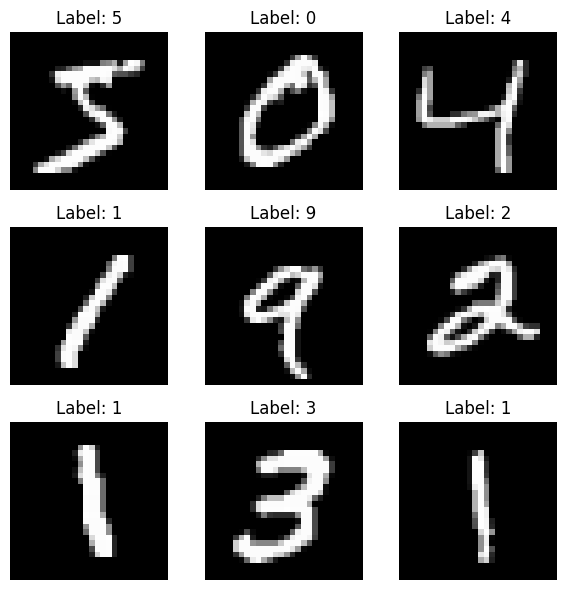

In [5]:
plt.figure(figsize=(6, 6))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(X_train[i], cmap="gray")
    plt.title(f"Label: {Y_train[i]}")
    plt.axis("off")
plt.tight_layout()
plt.show()

##Genel boyutlandırma

In [6]:
X_train = X_train.reshape((40000, 28, 28, 1))
X_test = X_test.reshape((8000, 28, 28, 1))
Y_train = Y_train.reshape((40000,1))
Y_test = Y_test.reshape((8000,1))
print('X_train.xhape',X_train.shape)
print('Y_train.xhape',Y_train.shape)
print('X_Test.xhape',X_test.shape)
print('Y_test.xhape',Y_test.shape)

X_train_norm,X_test_norm =X_train/255.0 ,X_test/255.0

X_train.xhape (40000, 28, 28, 1)
Y_train.xhape (40000, 1)
X_Test.xhape (8000, 28, 28, 1)
Y_test.xhape (8000, 1)


###LeNet Data Prepation

In [7]:
LeNet_train_ds,LeNet_test_ds=prepare_data(X_train_norm,Y_train,X_test_norm,Y_test,batch_size=32)

for batch in LeNet_train_ds.take(1):  # İlk batch'i alarak örnek veri yapısını yazdır
    images, labels = batch
    print("Train Data Set")
    print(f"Image batch shape: {images.shape}")
    print(f"Label batch shape: {labels.shape}")
for batch in LeNet_test_ds.take(1):  # İlk batch'i alarak örnek veri yapısını yazdır
    images, labels = batch
    print("Test Data Set")
    print(f"Image batch shape {images.shape}")
    print(f"Label batch shape: {labels.shape}")


Train Data Set
Image batch shape: (32, 28, 28, 1)
Label batch shape: (32, 1)
Test Data Set
Image batch shape (32, 28, 28, 1)
Label batch shape: (32, 1)


###MobilNetV2 Data Prepation

In [8]:
X_train_rgb = np.repeat(X_train_norm, 3, axis=-1)
X_test_rgb = np.repeat(X_test_norm, 3, axis=-1)
print(X_train_rgb.shape,X_test_rgb.shape)

X_train_resized = tf.image.resize(X_train_rgb, [96, 96])
X_test_resized = tf.image.resize(X_test_rgb, [96, 96])
print(X_train_resized.shape,X_test_resized.shape)

MobilNetV2_train_ds,MobilNetV2_test_ds=prepare_data(X_train_resized,Y_train,X_test_resized,Y_test,batch_size=128)
for batch in MobilNetV2_train_ds.take(1):  # İlk batch'i alarak örnek veri yapısını yazdır
    images, labels = batch
    print("Train Data Set")
    print(f"Image batch shape: {images.shape}")
    print(f"Label batch shape: {labels.shape}")
for batch in MobilNetV2_test_ds.take(1):  # İlk batch'i alarak örnek veri yapısını yazdır
    images, labels = batch
    print("Test Data Set")
    print(f"Image batch shape: {images.shape}")
    print(f"Label batch shape: {labels.shape}")

(40000, 28, 28, 3) (8000, 28, 28, 3)
(40000, 96, 96, 3) (8000, 96, 96, 3)
Train Data Set
Image batch shape: (128, 96, 96, 3)
Label batch shape: (128, 1)
Test Data Set
Image batch shape: (128, 96, 96, 3)
Label batch shape: (128, 1)


#LeNet

###Model

In [9]:
LeNet_model=Sequential([
    Input(shape=(28,28,1)),
    layers.Conv2D(6,(5,5),activation="tanh"),
    layers.AveragePooling2D(pool_size=(2,2)),
    layers.Conv2D(16,(5,5),activation="tanh"),
    layers.AveragePooling2D(pool_size=(2,2)),
    layers.Flatten(),
    layers.Dense(120, activation="tanh"),
    layers.Dense(84,activation="tanh"),
    layers.Dense(10,activation="softmax")

])
LeNet_model.summary()
LeNet_model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics= [metrics.SparseCategoricalAccuracy(name="accuracy")]
              )

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 24, 24, 6)           │             156 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d (AveragePooling2D) │ (None, 12, 12, 6)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 8, 8, 16)            │           2,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_1                  │ (None, 4, 4, 16)            │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 120)                 │          30,840 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 84)                  │          10,164 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │             850 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 44,426 (173.54 KB)

 Trainable params: 44,426 (173.54 KB)

 Non-trainable params: 0 (0.00 B)

###CallBacks


In [10]:
LeNet_Early_stop=EarlyStopping(monitor="val_loss",
                         patience=3,
                         verbose=1)
LeNet_model_chehpoint=ModelCheckpoint("LeNet.keras",
                               monitor="val_loss",
                               save_best_only=True,
                               verbose=1)

###Eğitim

In [11]:
LeNet_histroy=LeNet_model.fit(LeNet_train_ds,
                  validation_data=LeNet_test_ds,
                  epochs=50,
                  callbacks=[LeNet_Early_stop,LeNet_model_chehpoint])

Epoch 1/50
1248/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8543 - loss: 0.5048
Epoch 1: val_loss improved from inf to 0.14365, saving model to LeNet.keras
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 27s 19ms/step - accuracy: 0.8544 - loss: 0.5042 - val_accuracy: 0.9589 - val_loss: 0.1436
Epoch 2/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9636 - loss: 0.1202
Epoch 2: val_loss improved from 0.14365 to 0.09729, saving model to LeNet.keras
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 44s 21ms/step - accuracy: 0.9636 - loss: 0.1201 - val_accuracy: 0.9706 - val_loss: 0.0973
Epoch 3/50
1247/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9761 - loss: 0.0751
Epoch 3: val_loss improved from 0.09729 to 0.06948, saving model to LeNet.keras
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 23s 18ms/step - accuracy: 0.9761 - loss: 0.0751 - val_accuracy: 0.9780 - val_loss: 0.0695
Epoch 4/50
1249/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9843 - loss: 0.0533
Epoch 4: val_loss improved from 0.06948 to 0.

Best epoch details: {'accuracy': 0.9934499859809875, 'loss': 0.019381027668714523, 'val_accuracy': 0.9838749766349792, 'val_loss': 0.05143991485238075, 'best_epoch': 9}


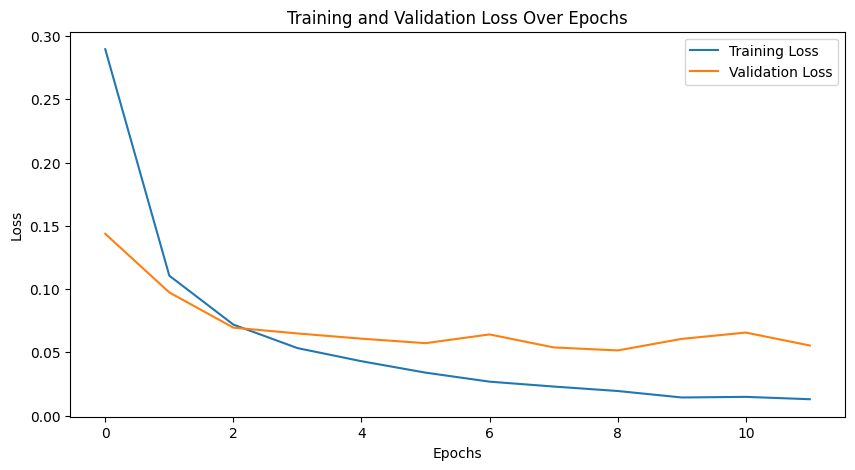

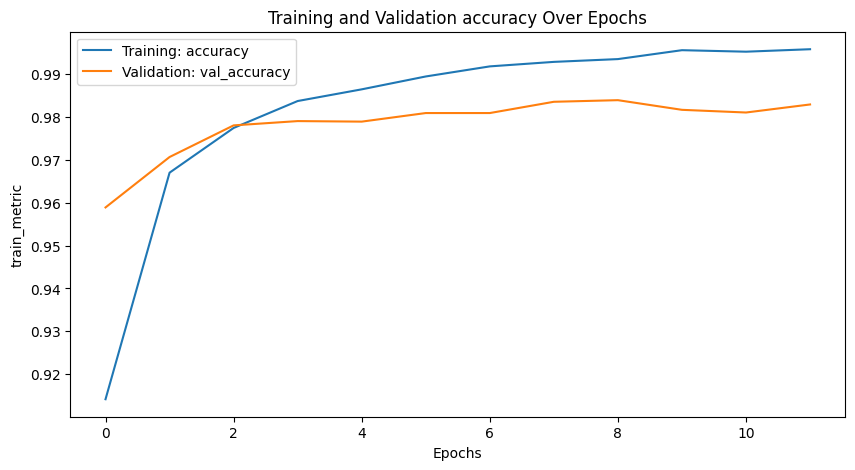

In [12]:
get_best_epoch_details(LeNet_histroy)
plot_training_history(LeNet_histroy)

In [26]:
LeNet_model.save(Save_path+"LeNet_model.keras")

#MobilNet

###MobilNetV2 BackBone

In [14]:
from keras.applications.mobilenet_v2 import MobileNetV2 , preprocess_input as preprogress_input_mobilenet

In [15]:
MobileNetV2_Backbone=MobileNetV2(include_top=False,
                              alpha=0.35 ,#alpha=0.5, aşırı uyumu önlemeye yardımcı olmak için modelin karmaşıklığını azaltır
                             input_shape=(96,96,3))
print(f"total number of layers in mobilNet {len(MobileNetV2_Backbone.layers)}")

total number of layers in mobilNet 154


In [16]:
MobileNetV2_Backbone.summary()

Model: "mobilenetv2_0.35_96"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 96, 96, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 48, 48, 16)     │            432 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 48, 48, 16)     │             64 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 48, 48, 16)     │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 48, 48, 16)     │            144 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 48, 48, 16)     │             64 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 48, 48, 16)     │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 48, 48, 8)      │            128 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 48, 48, 8)      │             32 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 48, 48, 48)     │            384 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 48, 48, 48)     │            192 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 48, 48, 48)     │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 49, 49, 48)     │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 24, 24, 48)     │            432 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├──────────────────────

 Total params: 410,208 (1.56 MB)

 Trainable params: 396,128 (1.51 MB)

 Non-trainable params: 14,080 (55.00 KB)

###Eğitilebilirlik

In [17]:
for layer in MobileNetV2_Backbone.layers:
  layer.trainable=False

for layer in MobileNetV2_Backbone.layers[9:18]:# MobilNetV2 mimarisinin ilk buluğu aktif
  layer.trainable=True
for layer in MobileNetV2_Backbone.layers:
  print(f"{layer.name} : {layer.trainable}")

input_layer_1 : False
Conv1 : False
bn_Conv1 : False
Conv1_relu : False
expanded_conv_depthwise : False
expanded_conv_depthwise_BN : False
expanded_conv_depthwise_relu : False
expanded_conv_project : False
expanded_conv_project_BN : False
block_1_expand : True
block_1_expand_BN : True
block_1_expand_relu : True
block_1_pad : True
block_1_depthwise : True
block_1_depthwise_BN : True
block_1_depthwise_relu : True
block_1_project : True
block_1_project_BN : True
block_2_expand : False
block_2_expand_BN : False
block_2_expand_relu : False
block_2_depthwise : False
block_2_depthwise_BN : False
block_2_depthwise_relu : False
block_2_project : False
block_2_project_BN : False
block_2_add : False
block_3_expand : False
block_3_expand_BN : False
block_3_expand_relu : False
block_3_pad : False
block_3_depthwise : False
block_3_depthwise_BN : False
block_3_depthwise_relu : False
block_3_project : False
block_3_project_BN : False
block_4_expand : False
block_4_expand_BN : False
block_4_expand_relu

###Model

In [18]:
MobilNetV2_model=models.Sequential([
    MobileNetV2_Backbone,
    layers.GlobalAveragePooling2D(),
    layers.Dense(32,activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(10,activation="softmax")
])
MobilNetV2_optimizer = SGD(
    learning_rate=0.0005,
    momentum=0.9,
    weight_decay=0.005
    )
MobilNetV2_model.compile(optimizer=MobilNetV2_optimizer,
                          loss="sparse_categorical_crossentropy",
                          metrics= [metrics.SparseCategoricalAccuracy(name="accuracy")]
                          )

###CallBacks

In [19]:
MobilNetV2_Early_stop=EarlyStopping(monitor="val_loss",
                         patience=2,
                         restore_best_weights=True,
                         verbose=1)
MobilNetV2_model_chehpoint=ModelCheckpoint("MobilNetV2.keras",
                               monitor="val_loss",
                               save_best_only=True,
                               save_weights_only=False,
                               verbose=1)

###Eğitim

In [20]:
start_time=datetime.datetime.now()
MobilNetV2_History=MobilNetV2_model.fit(MobilNetV2_train_ds,
                                        validation_data=MobilNetV2_test_ds,
                                        epochs=10,
                                        callbacks=[MobilNetV2_Early_stop,MobilNetV2_model_chehpoint])

end_time=datetime.datetime.now()
print(str(end_time-start_time))


Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4630 - loss: 1.6184
Epoch 1: val_loss improved from inf to 1.65922, saving model to MobilNetV2.keras
313/313 ━━━━━━━━━━━━━━━━━━━━ 382s 1s/step - accuracy: 0.4636 - loss: 1.6170 - val_accuracy: 0.4250 - val_loss: 1.6592
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8272 - loss: 0.5817
Epoch 2: val_loss improved from 1.65922 to 1.23886, saving model to MobilNetV2.keras
313/313 ━━━━━━━━━━━━━━━━━━━━ 400s 1s/step - accuracy: 0.8273 - loss: 0.5816 - val_accuracy: 0.5842 - val_loss: 1.2389
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8720 - loss: 0.4309
Epoch 3: val_loss improved from 1.23886 to 1.11345, saving model to MobilNetV2.keras
313/313 ━━━━━━━━━━━━━━━━━━━━ 414s 1s/step - accuracy: 0.8720 - loss: 0.4308 - val_accuracy: 0.6382 - val_loss: 1.1134
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8998 - loss: 0.3457
Epoch 4: val_loss improved from 1.11345 to 0.99559, sav

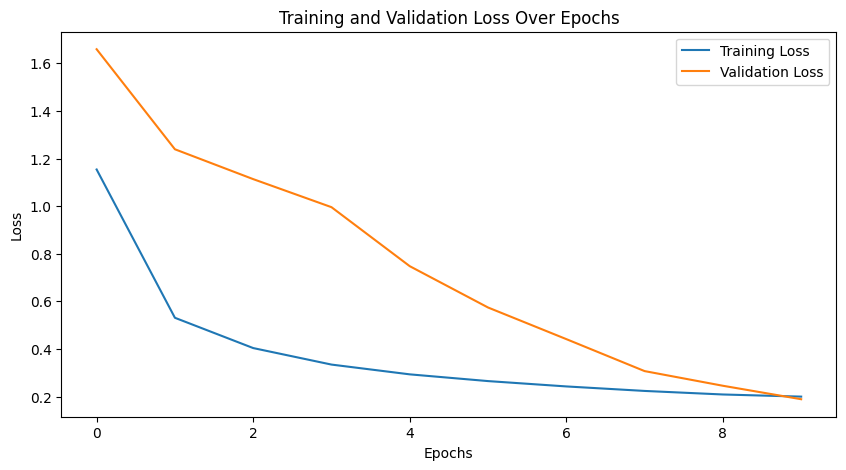

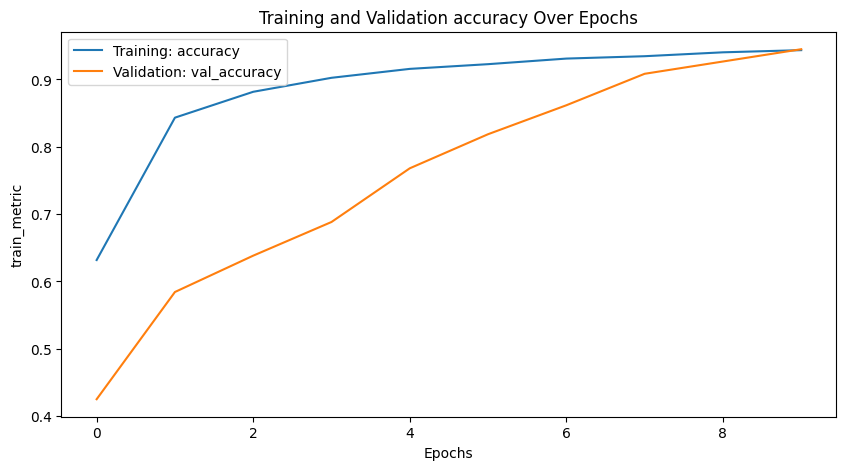

Best epoch details: {'accuracy': 0.9434999823570251, 'loss': 0.19959649443626404, 'val_accuracy': 0.9448750019073486, 'val_loss': 0.1886948198080063, 'best_epoch': 10}


In [21]:
plot_training_history(MobilNetV2_History)
get_best_epoch_details(MobilNetV2_History)

In [25]:
MobilNetV2_model.save(Save_path+"MobilNetV2_model.keras")

#Test Model

##Data Preprogres

In [48]:
def get_data_preprogresing(img,img_show=False):
    ### LeNet data preprogres
    img_resized_lenet = cv2.resize(img, (28, 28))
    LeNet_data = cv2.cvtColor(img_resized_lenet, cv2.COLOR_RGB2GRAY)
    LeNet_data = np.expand_dims(LeNet_data, axis=-1)
    LeNet_data = LeNet_data / 255.0
    ###

    ### obilNetV2 data preprogres
    img_resized_mobilenet = cv2.resize(img, (96,96))
    MobilNetV2_data = img_resized_mobilenet / 255.0
    ###

    if img_show:
      plt.figure(figsize=(6, 6))
      plt.imshow(LeNet_data, cmap="gray")
      plt.show()

    LeNet_data = tf.expand_dims(LeNet_data, axis=0)
    MobilNetV2_data = tf.expand_dims(MobilNetV2_data, axis=0)
    return LeNet_data, MobilNetV2_data


def get_pred(pred):
  predicted_class = np.argmax(pred, axis=-1)

  print(f"En iyi tahmin edilen sınıf: {predicted_class}")
  return predicted_class
from google.colab.patches import cv2_imshow

def get_img(path):
  img = cv2.imread(path)
  return img

##Prediction

###Load Model

In [ ]:
LenNet_model_load=load_model("/content/drive/MyDrive/model deneme/LeNet_model.keras")
MobilNetV2_model_load=load_model("/content/drive/MyDrive/model deneme/MobilNetV2_model.keras")

###Pred

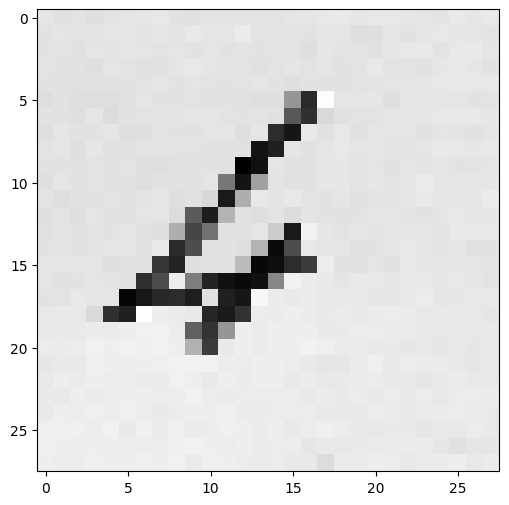

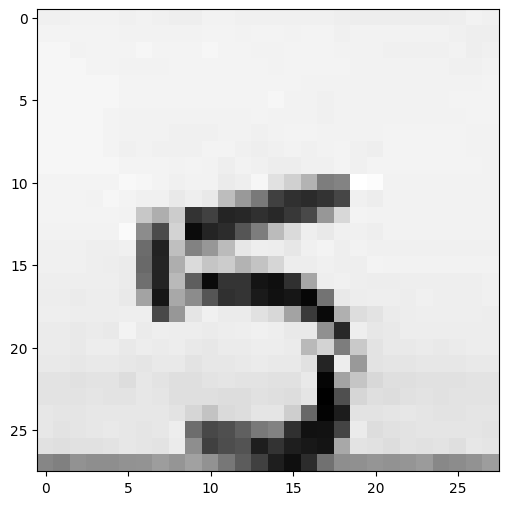

In [36]:
img_path1=("/content/drive/MyDrive/model deneme/4.jpg")
img_path2=("/content/drive/MyDrive/model deneme/5.jpg")

img1=get_img(img_path1)
img2=get_img(img_path2)

LeNet_data_1,MobilNetV2_data_1=get_data_preprogresing(img1,img_show=True)
LeNet_data_2,MobilNetV2_data_2=get_data_preprogresing(img2,img_show=True)


In [39]:
leNet_pred_1=LenNet_model_load.predict(LeNet_data_1)
leNet_pred_2=LenNet_model_load.predict(LeNet_data_2)
mobilNetV2_pred_1=MobilNetV2_model.predict(MobilNetV2_data_1)
mobilNetV2_pred_2=MobilNetV2_model.predict(MobilNetV2_data_2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


In [52]:
LN_pred1=get_pred(leNet_pred_1)
LN_pred2=get_pred(leNet_pred_2)
MN_pred1=get_pred(mobilNetV2_pred_1)
MN_pred2=get_pred(mobilNetV2_pred_2)
print(f"gerçek değer:4 tahmin{LN_pred1}")
print(f"gerçek değer:5 tahmin{LN_pred2}")
print(f"gerçek değer:4 tahmin{MN_pred1}")
print(f"gerçek değer:5 tahmin{MN_pred2}")

En iyi tahmin edilen sınıf: [8]
En iyi tahmin edilen sınıf: [8]
En iyi tahmin edilen sınıf: [4]
En iyi tahmin edilen sınıf: [3]
gerçek değer:4 tahmin[8]
gerçek değer:5 tahmin[8]
gerçek değer:4 tahmin[4]
gerçek değer:5 tahmin[3]
